# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe

def loadJsonToDataFrame(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.json_normalize(data)
    return df


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
df = loadJsonToDataFrame('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [8]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [9]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

df['input_tokens'] = df['input'].apply(lambda x: x.split())
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())


In [11]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(lambda x: len(x))
df['pos_length'] = df['pos_tokens'].apply(lambda x: len(x))


In [13]:
# check for the equality of input_length and pos_length in the dataframe
df['length_check'] = df.apply(lambda x: x['input_length'] == x['pos_length'], axis=1)

# display the first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length  length_check
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31          True
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew,

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df):
    # Get all unique labels from the 'pos' column
    labels = set()
    for pos in df['pos_tokens']:
        labels.update(pos)
    return labels

# Get all unique labels from the 'pos' column

current_unique_labels = unique_labels(df)

# Print the unique labels
print(current_unique_labels)
df.shape


{'unit', 'quantity', 'ingredient'}


(285, 7)

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [15]:
# drop the irrelevant recipe data

df.drop(['input', 'pos'], axis=1, inplace=True)

# drop  the rows with length_check = False
df.drop(df[df['length_check'] == False].index, inplace=True)

df.shape




(280, 5)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [16]:
# update the input and pos length in input_length and pos_length

df['input_length'] = df['input_tokens'].apply(lambda x: len(x))
df['pos_length'] = df['pos_tokens'].apply(lambda x: len(x))


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [17]:
# validate the input length and pos length as input_length and pos_length

df['length_check'] = df.apply(lambda x: x['input_length'] == x['pos_length'], axis=1)

# check for rows with length_check = False
print(df[df['length_check'] == False].shape)


# drop the columns input_length, pos_length and length_check
df.drop(['input_length', 'pos_length', 'length_check'], axis=1, inplace=True)

(0, 5)


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [18]:
# split the dataset into training and validation sets

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [19]:
# print the first five rows of train_df

train_df.head()


input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  pos_tokens
89                                                                                                                                                                                          [1/2, cup, Sooji, Semolina, Rava, teaspoon, Ghee, 3, cups, Milk, 3/4, Sugar, 5, Saffron, strands, 1, Cardamom, Elaichi, Pods, Seeds, Cashew, nuts, Raisins, Mixed, dry, fruits, chopped]                                                                                                                                                                                                                                                    [quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
140                                                                                                                                                                                                                                                                          [50, grams, Wheat, Grass, Powder, 1/2, teaspoon, Black, pepper, powder, 1, Cumin, Jeera, Lemon, juiced]                                                                                                                                                                                                                                                                                                                                                                                          [quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient]
188  [2, cups, Potatoes, Aloo, 1, Tomatoes, finely, chopped, 1-1/2, tablespoon, Ginger, grated, ground, Green, Chillies, slit, tablespoons, Kasuri, Methi, Dried, Fenugreek, Leaves, 1/2, teaspoon, Fennel, seeds, Saunf, Cumin, Jeera, Seeds, Coriander, Powder, Dhania, Red, Chilli, powder, Turmeric, Haldi, Garam, masala, teaspoons, Amchur, Dry, Mango, Ghee, Salt, to, taste]  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
5                                                                                  [1, cup, Rice, 1/2, Yellow, Moong, Dal, Mint, Leaves, 1/4, Coriander, Dhania, Green, Chilli, inch, Ginger, teaspoon, Cumin, seeds, 5, cups, Water, Sunflower, Oil, Salt, 2, tablespoons, Ghee, 8, Cashew, nuts, halved, Whole, Black, Peppercorns, sprig, Curry, leaves, pinch, Asafoetida, hing]                                                                                                      [quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, i

In [20]:
# print the first five rows of the val_df

val_df.head()


input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens
35                                                                                                                                                                                                                                                                                                                                [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]
111  [1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]  [quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
245                                                                                                                                                                [1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]                                                                                                                                                                                                                                          [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
264                                                                                                                                                                                                                

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [21]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens']
y_train = train_df['pos_tokens']
X_val = val_df['input_tokens']
y_val = val_df['pos_tokens']


In [22]:
# validate the shape of training and validation samples

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# check the first five rows of X_train and y_train

y_train.head()



X_train shape: (224,)
y_train shape: (224,)
X_val shape: (56,)
y_val shape: (56,)


89                                                                                                                                                                                                                                                       [quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
140                                                                                                                                                                                                                                                                                                                                                                                            [quantity, unit, ingredient, ingredient, ingredient, quantity, unit, in

###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [23]:
# Display the number of unique labels present in y_train

print(f"Number of unique labels in y_train: {set([item for sublist in y_train for item in sublist])}")


Number of unique labels in y_train: {'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [24]:
# flatten the list for nested_list (input_tokens, pos_tokens)

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

# Flatten the y_train and y_val lists
X_train_flat = flatten_list(X_train)
y_train_flat = flatten_list(y_train)
X_val_flat = flatten_list(X_val)
y_val_flat = flatten_list(y_val)

# Display the first 10 elements of the flattened lists
print("X_train:", X_train[:10])
print("Flattened X_train:", X_train_flat[:10])
print("Flattened y_train:", y_train_flat[:10])

# Display the first 10 elements of the flattened lists
print("Flattened X_val:", X_val_flat[:10])
print("Flattened y_val:", y_val_flat[:10])






X_train: 89                                                                                                                                                                                            [1/2, cup, Sooji, Semolina, Rava, teaspoon, Ghee, 3, cups, Milk, 3/4, Sugar, 5, Saffron, strands, 1, Cardamom, Elaichi, Pods, Seeds, Cashew, nuts, Raisins, Mixed, dry, fruits, chopped]
140                                                                                                                                                                                                                                                                            [50, grams, Wheat, Grass, Powder, 1/2, teaspoon, Black, pepper, powder, 1, Cumin, Jeera, Lemon, juiced]
188    [2, cups, Potatoes, Aloo, 1, Tomatoes, finely, chopped, 1-1/2, tablespoon, Ginger, grated, ground, Green, Chillies, slit, tablespoons, Kasuri, Methi, Dried, Fenugreek, Leaves, 1/2, teaspoon, Fennel, seeds, Saunf, Cumin, Jeera, Seeds, 

In [25]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [26]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):
    # Flatten the input_tokens and pos_tokens
    X_flat = flatten_list(df['input_tokens'])
    y_flat = flatten_list(df['pos_tokens'])

    # Validate the length of the flattened lists
    if len(X_flat) != len(y_flat):
        print(f"Length mismatch in {dataset_name} dataset: {len(X_flat)} vs {len(y_flat)}")
        return None, None

    # Display the first 10 records
    print(f"First 10 records in {dataset_name} dataset:")
    for i in range(10):
        print(f"Input: {X_flat[i]}, POS: {y_flat[i]}")

    return X_flat, y_flat





In [27]:
# extract the tokens and its pos tags

X_train_flat, y_train_flat = extract_and_validate_tokens(train_df, 'Training')
print('.........')
X_val_flat, y_val_flat = extract_and_validate_tokens(val_df, 'Validation')
print('.........')

# check the first 10 records of X_train_flat and y_train_flat
print("X_train_flat", X_train_flat[:10])
print('.........')
print("y_train_flat", y_train_flat[:10])
print('.........')
# check the first 10 records of X_val_flat and y_val_flat
print("X_val_flat",X_val_flat[:10])
print('.........')
print("y_val_flat",y_val_flat[:10])



First 10 records in Training dataset:
Input: 1/2, POS: quantity
Input: cup, POS: unit
Input: Sooji, POS: ingredient
Input: Semolina, POS: ingredient
Input: Rava, POS: ingredient
Input: teaspoon, POS: unit
Input: Ghee, POS: ingredient
Input: 3, POS: quantity
Input: cups, POS: unit
Input: Milk, POS: ingredient
.........
First 10 records in Validation dataset:
Input: 1, POS: quantity
Input: cup, POS: unit
Input: Ada, POS: ingredient
Input: 2, POS: quantity
Input: liter, POS: unit
Input: Milk, POS: ingredient
Input: 3/4, POS: quantity
Input: Sugar, POS: ingredient
Input: tablespoon, POS: unit
Input: Ghee, POS: ingredient
.........
X_train_flat ['1/2', 'cup', 'Sooji', 'Semolina', 'Rava', 'teaspoon', 'Ghee', '3', 'cups', 'Milk']
.........
y_train_flat ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient']
.........
X_val_flat ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
.........
y_val_flat ['q

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [28]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):

    ingredient = []
    unit = []
    quantity = []

    for token, pos in zip(tokens, pos_tags):
        if pos == 'ingredient':
            ingredient.append(token)
        elif pos == 'unit':
            unit.append(token)
        elif pos == 'quantity':
            quantity.append(token)

    # Validate the lists
    if not all(label in ['ingredient', 'unit', 'quantity'] for label in pos_tags):
        print("Invalid labels found in the data.")
        return [], [], []

    return ingredient, unit, quantity



In [29]:
#  call the function to categorise the labels into respective list

ingredient_train, unit_train, quantity_train = categorize_tokens(X_train_flat, y_train_flat)
ingredient_val, unit_val, quantity_val = categorize_tokens(X_val_flat, y_val_flat)
# check the first 10 records of ingredient_train, unit_train and quantity_train
print("Ingredient Train:", ingredient_train[:10])
print("Unit Train:", unit_train[:10])
print("Quantity Train:", quantity_train[:10])

print('.........')
# check the first 10 records of ingredient_val, unit_val and quantity_val
print("Ingredient Validation:", ingredient_val[:10])
print("Unit Validation:", unit_val[:10])
print("Quantity Validation:", quantity_val[:10])


Ingredient Train: ['Sooji', 'Semolina', 'Rava', 'Ghee', 'Milk', 'Sugar', 'Saffron', 'strands', 'Cardamom', 'Elaichi']
Unit Train: ['cup', 'teaspoon', 'cups', 'grams', 'teaspoon', 'cups', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons']
Quantity Train: ['1/2', '3', '3/4', '5', '1', '50', '1/2', '1', '2', '1']
.........
Ingredient Validation: ['Ada', 'Milk', 'Sugar', 'Ghee', 'Cardamom', 'Powder', 'Elaichi', 'Carrot', 'Gajjar', 'chopped']
Unit Validation: ['cup', 'liter', 'tablespoon', 'teaspoon', 'cups', 'tablespoon', 'teaspoons', 'cup', 'teaspoon', 'inch']
Quantity Validation: ['1', '2', '3/4', '1/2', '1', '7', '2', '1/2', '6', '3']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [30]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name):
    # Count the frequency of each item
    item_counts = Counter(item_list)

    # Get the most common items
    top_items = item_counts.most_common(10)

    # Display the top items
    print(f"Top 10 {pos_label} in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items

In [31]:
# get the top ingredients which are frequently seen in the recipe

top_ingredients_train = get_top_frequent_items(ingredient_train, 'Ingredients', 'Training')
top_ingredients_val = get_top_frequent_items(ingredient_val, 'Ingredients', 'Validation')

Top 10 Ingredients in Training dataset:
powder: 148
Salt: 116
seeds: 103
Oil: 94
chopped: 93
Red: 93
Green: 91
Chilli: 89
Coriander: 82
Sunflower: 75
Top 10 Ingredients in Validation dataset:
powder: 35
Salt: 33
Oil: 28
Red: 27
Green: 24
Chilli: 24
chopped: 22
seeds: 22
Leaves: 20
Garlic: 17


In [32]:
# get the top units which are frequently seen in the recipe

top_units_train = get_top_frequent_items(unit_train, 'Units', 'Training')
top_units_val = get_top_frequent_items(unit_val, 'Units', 'Validation')



Top 10 Units in Training dataset:
teaspoon: 182
cup: 149
tablespoon: 109
grams: 75
tablespoons: 70
inch: 59
cups: 56
sprig: 48
teaspoons: 45
cloves: 45
Top 10 Units in Validation dataset:
cup: 44
teaspoon: 39
tablespoons: 23
tablespoon: 22
cups: 18
sprig: 14
inch: 13
teaspoons: 12
cloves: 10
grams: 7


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [33]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_items, label, dataset_name):
    # Unzip the top items into two lists
    items, counts = zip(*top_items)

    # Create a DataFrame for better plotting
    df = pd.DataFrame({'Item': items, 'Count': counts})

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Item', data=df)
    plt.title(f'Top 10 {label} in {dataset_name} dataset')
    plt.xlabel('Count')
    plt.ylabel(label)
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



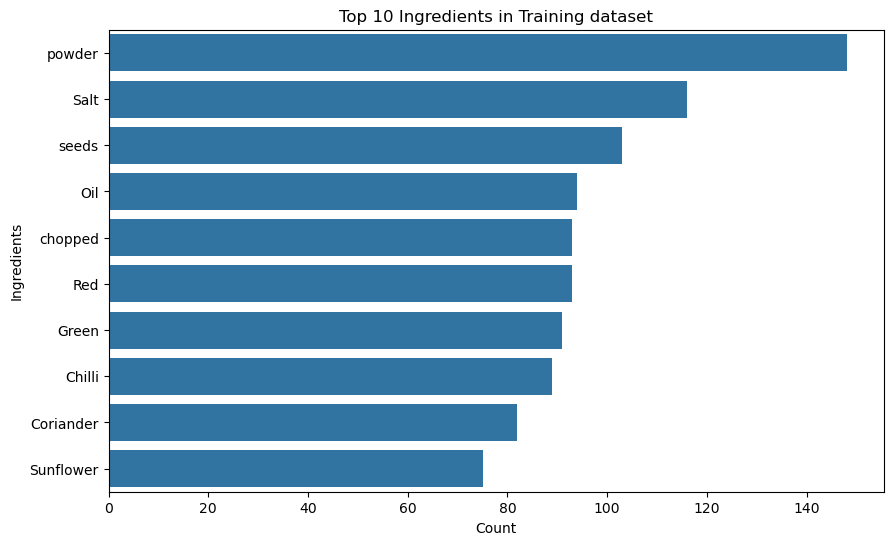

In [34]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients_train, 'Ingredients', 'Training')

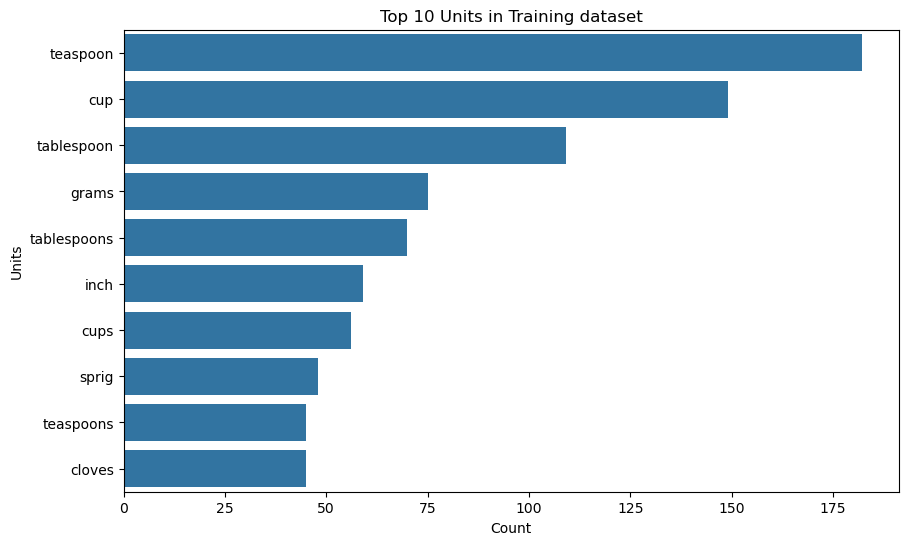

In [35]:
# plot the top frequent units in training data
plot_top_items(top_units_train, 'Units', 'Training')


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [36]:
# initialise the dataset_name
dataset_name = 'Validation'


In [37]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe

X_val_flat, y_val_flat = extract_and_validate_tokens(val_df, dataset_name)
ingredient_val, unit_val, quantity_val = categorize_tokens(X_val_flat, y_val_flat)
top_ingredients_val = get_top_frequent_items(ingredient_val, 'Ingredients', dataset_name)
top_units_val = get_top_frequent_items(unit_val, 'Units', dataset_name)


First 10 records in Validation dataset:
Input: 1, POS: quantity
Input: cup, POS: unit
Input: Ada, POS: ingredient
Input: 2, POS: quantity
Input: liter, POS: unit
Input: Milk, POS: ingredient
Input: 3/4, POS: quantity
Input: Sugar, POS: ingredient
Input: tablespoon, POS: unit
Input: Ghee, POS: ingredient
Top 10 Ingredients in Validation dataset:
powder: 35
Salt: 33
Oil: 28
Red: 27
Green: 24
Chilli: 24
chopped: 22
seeds: 22
Leaves: 20
Garlic: 17
Top 10 Units in Validation dataset:
cup: 44
teaspoon: 39
tablespoons: 23
tablespoon: 22
cups: 18
sprig: 14
inch: 13
teaspoons: 12
cloves: 10
grams: 7


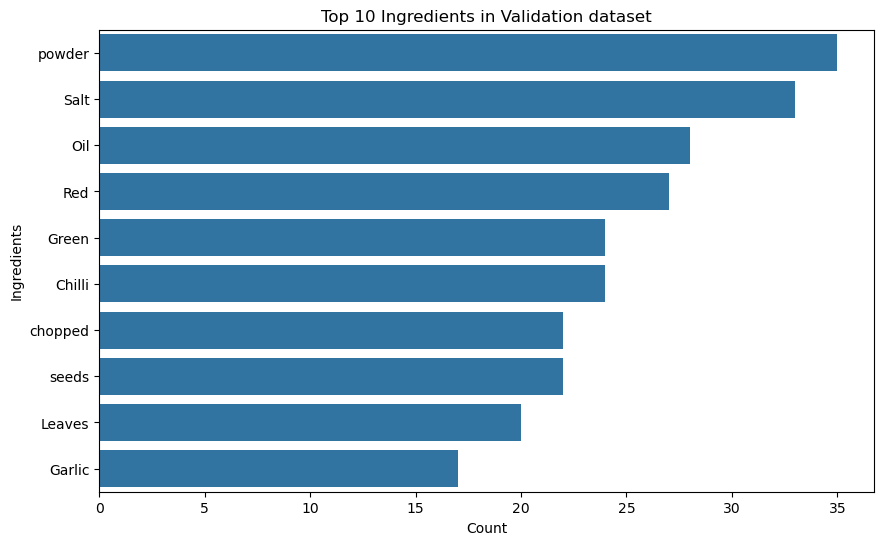

In [38]:
# plot the top frequent ingredients in validation data
plot_top_items(top_ingredients_val, 'Ingredients', dataset_name)


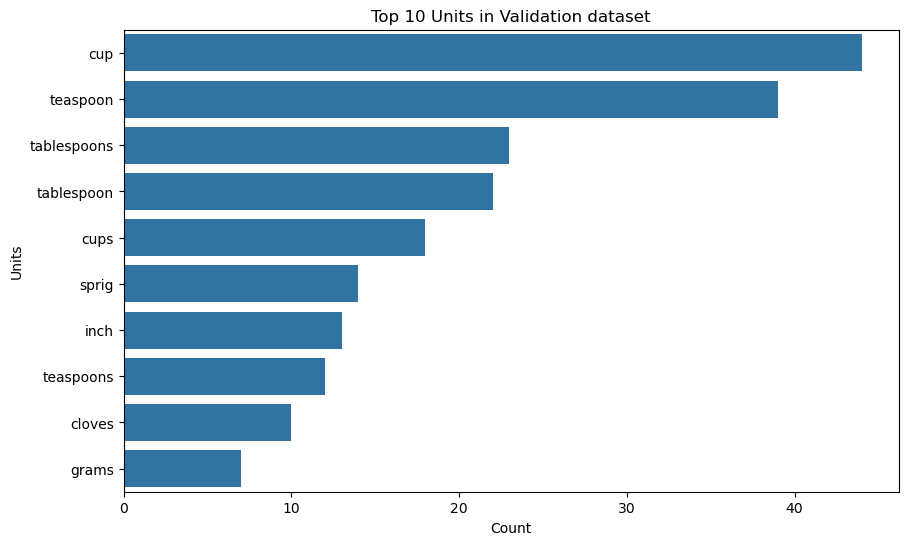

In [39]:
# plot the top frequent units in validation data
plot_top_items(top_units_val, 'Units', dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [40]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = list(set(unit_train))
print("Unique Unit Keywords:", unit_keywords)

quantity_keywords = list(set(quantity_train))
print("Unique Quantity Keywords:", quantity_keywords)

quantity_pattern = r'^\d+(\.\d+)?$'  # Matches whole numbers and decimals


Unique Unit Keywords: ['tablespoon', 'cloves', 'green', 'scoops', 'sprigs', 'raw', 'thick', 'Tablespoons', 'tablespoons', 'medium', 'cup', 'gms', 'for', 'sprig', 'inches', 'or', 'tsp', 'thin', 'fistful', 'Pinch', 'grams', 'tbsp', 'finely', 'inch', 'teaspoon', 'liter', 'pinch', 'kg', 'whole', 'cups', 'small', 'ml', 'Teaspoon', 'gram', 'chopped', 'dry', 'Tbsp', 'red', 'Small', 'drops', 'cut', 'Spoon', 'Stalks', 'a', 'long', 'Tablespoon', 'clove', 'wedges', 'Sprig', 'handful', 'teaspoons', 'spoon']
Unique Quantity Keywords: ['175', '3/4', '1/3', 'cloves', '225', '80', '2', '125', '300', '1/2', '1/4', '250', '8', '6', '20', '18', 'for', '4', '1.5', 'little', 'taste', 'one', 'Few', 'per', '1-2', 'Little', '5-6', '2-3', '2-1', 'A', '3-4', '1-1/4', '7', '24', 'finely', '10', '2.5', 'pinch', '400', '1/8', '30', 'as', '5', '350', 'to', '7-8', '75', '12', '500', 'a', '1-1/2', '15', '3', '4-5', '1-3/4', '600', 'two', '2-1/2', 'few', '200', '50', '160', '1', '100', '150']


In [41]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token. 
    - `lemma` - The lowercase lemma (base form) of the token. 
    - `pos_tag` - Part-of-speech (POS) tag of the token. 
    - `tag` - Detailed POS tag of the token. 
    - `dep` - Dependency relation of the token in the sentence. 
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk"). 
    - `is_stop` - Boolean indicating if the token is a stopword. 
    - `is_digit` - Boolean indicating if the token consists of only digits. 
    - `has_digit` - Boolean indicating if the token contains at least one digit. 
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character. 
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-). 
    - `slash_present` - Boolean indicating if the token contains a slash (/). 
    - `is_title` - Boolean indicating if the token starts with an uppercase letter. 
    - `is_upper` - Boolean indicating if the token is fully uppercase. 
    - `is_punct` - Boolean indicating if the token is a punctuation mark. 

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [42]:
print("hypenathed=%s" % ('-' in "2-cups"))

hypenathed=True


In [43]:
# define word2features for processing each token in the sentence sent by using index i.

def word2features(sent, i):

    # Process the entire sentence with spaCy
    doc = nlp(sent)
    word = doc[i]
    postag = word.pos_

    print(f"Processing word: {word.text}, POS tag: {postag}")

    features = [
        # --- Core Features ---
        "bias=%s" % 1.0,  # Bias feature
        "token=%s" % word.text.lower(),  # The word itself
        "lemma=%s" % word.lemma_,  # Lemma of the word
        "pos_tag=%s" % postag,  # Part-of-speech tag
        "tag=%s" % word.tag_,  # Detailed part-of-speech tag
        "dep=%s" % word.dep_,  # Dependency relation
        "shape=%s" % word.shape_,  # Shape of the word (e.g., "Xxxx", "xxxx")
        "is_stop=%s" % word.is_stop,  # Whether the word is a stop word
        "is_digit=%s" % word.text.isdigit(),  # Whether the word is a digit
        "has_digit=%s" % any(char.isdigit() for char in word.text),  # Whether the word contains a digit
        "has_alpha=%s" % any(char.isalpha() for char in word.text),  # Whether the word contains an alphabetic character
        "hyphenated=%s" % ('-' in word.text),  # Whether the word contains a hyphen
        "slash_present=%s" % ('/' in word.text),  # Whether the word contains a slash
        "is_title=%s" % word.text.istitle(),  # Whether the word is title-cased
        "is_upper=%s" % word.text.isupper(),  # Whether the word is in uppercase
        "is_punct=%s" % word.is_punct,  # Whether the word is punctuation
    
        # --- Improved Quantity & Unit Detection ---

        "is_quantity=%s" % any(q in word.text for q in quantity_keywords),  # Whether the word is a quantity
        "is_unit=%s" % any(u in word.text for u in unit_keywords),  # Whether the word is a unit
        "is_numeric=%s" % (re.match(quantity_pattern, word.text) is not None),  # Whether the word is numeric (whole number or decimal)
        "is_fraction=%s" % ('/' in word.text and re.match(r'^\d+/\d+$', word.text) is not None),  # Whether the word is a fraction
        "is_decimal=%s" % (re.match(r'^\d+\.\d+$', word.text) is not None),  # Whether the word is a decimal number
        "preceding_word=%s" % doc[i - 1].text if i > 0 else '',  # The word before the current word
        "following_word=%s" % doc[i + 1].text if i < (len(sent.split()) - 1) else '',  # The word after the current word

        # --- Contextual Features ---

        "prev_token=%s" % doc[i - 1].text if i > 0 else '',  # Previous token
        "prev_pos=%s" % doc[i - 1].pos_ if i > 0 else '',  # Previous token's POS tag
        "prev_is_quantity=%s" %( any(q in doc[i - 1].text for q in quantity_keywords) if i > 0 else False),  # Previous token is a quantity
        "prev_is_digit=%s" % (sent[i - 1].isdigit() if i > 0 else False),  # Previous token is a digit
        "BOS=%s" % (i == 0),  # Beginning of sentence
        "next_token=%s" % doc[i + 1].text if i < (len(sent.split()) - 1) else '',  # Next token
        "next_is_unit=%s" % (any(u in doc[i + 1].text for u in unit_keywords) if i < (len(sent.split()) - 1) else False),  # Next token is a unit
        "next_is_ingredient=%s" % (any(ing in doc[i + 1].text for ing in ingredient_train) if i < (len(sent.split()) - 1) else False),  # Next token is an ingredient
        "EOS=%s" % (i == (len(sent.split()) - 1))  # End of sentence
    ]
    print(f"Features for word '{word.text}': {features}")
    return features

# Example usage of word2features function

# Process a sample sentence
sample_sentence = "2 cups of flour and 1/2 cup of sugar"

# Extract features for each token in the sample sentence
features = [word2features(sample_sentence, i) for i in range(len(sample_sentence.split()))]


Processing word: 2, POS tag: NUM
Features for word '2': ['bias=1.0', 'token=2', 'lemma=2', 'pos_tag=NUM', 'tag=CD', 'dep=nummod', 'shape=d', 'is_stop=False', 'is_digit=True', 'has_digit=True', 'has_alpha=False', 'hyphenated=False', 'slash_present=False', 'is_title=False', 'is_upper=False', 'is_punct=False', 'is_quantity=True', 'is_unit=False', 'is_numeric=True', 'is_fraction=False', 'is_decimal=False', '', 'following_word=cups', '', '', 'prev_is_quantity=False', 'prev_is_digit=False', 'BOS=True', 'next_token=cups', 'next_is_unit=True', 'next_is_ingredient=False', 'EOS=False']
Processing word: cups, POS tag: NOUN
Features for word 'cups': ['bias=1.0', 'token=cups', 'lemma=cup', 'pos_tag=NOUN', 'tag=NNS', 'dep=ROOT', 'shape=xxxx', 'is_stop=False', 'is_digit=False', 'has_digit=False', 'has_alpha=True', 'hyphenated=False', 'slash_present=False', 'is_title=False', 'is_upper=False', 'is_punct=False', 'is_quantity=False', 'is_unit=True', 'is_numeric=False', 'is_fraction=False', 'is_decimal=Fa

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [44]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):
    print(f"Processing sentence: {sent}")
    joinedSent = ' '.join(sent)  # Join the sentence tokens into a single string
    print(f"Processing sentence: {joinedSent}")
    return [word2features(joinedSent, i) for i in range(len(sent))]



### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [45]:
X_train

89                                                                                                                                                                                            [1/2, cup, Sooji, Semolina, Rava, teaspoon, Ghee, 3, cups, Milk, 3/4, Sugar, 5, Saffron, strands, 1, Cardamom, Elaichi, Pods, Seeds, Cashew, nuts, Raisins, Mixed, dry, fruits, chopped]
140                                                                                                                                                                                                                                                                            [50, grams, Wheat, Grass, Powder, 1/2, teaspoon, Black, pepper, powder, 1, Cumin, Jeera, Lemon, juiced]
188    [2, cups, Potatoes, Aloo, 1, Tomatoes, finely, chopped, 1-1/2, tablespoon, Ginger, grated, ground, Green, Chillies, slit, tablespoons, Kasuri, Methi, Dried, Fenugreek, Leaves, 1/2, teaspoon, Fennel, seeds, Saunf, Cumin, Jeera, Seeds, Coriander

In [46]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]


Processing sentence: ['1/2', 'cup', 'Sooji', 'Semolina', 'Rava', 'teaspoon', 'Ghee', '3', 'cups', 'Milk', '3/4', 'Sugar', '5', 'Saffron', 'strands', '1', 'Cardamom', 'Elaichi', 'Pods', 'Seeds', 'Cashew', 'nuts', 'Raisins', 'Mixed', 'dry', 'fruits', 'chopped']
Processing sentence: 1/2 cup Sooji Semolina Rava teaspoon Ghee 3 cups Milk 3/4 Sugar 5 Saffron strands 1 Cardamom Elaichi Pods Seeds Cashew nuts Raisins Mixed dry fruits chopped
Processing word: 1/2, POS tag: NUM
Features for word '1/2': ['bias=1.0', 'token=1/2', 'lemma=1/2', 'pos_tag=NUM', 'tag=CD', 'dep=nummod', 'shape=d/d', 'is_stop=False', 'is_digit=False', 'has_digit=True', 'has_alpha=False', 'hyphenated=False', 'slash_present=True', 'is_title=False', 'is_upper=False', 'is_punct=False', 'is_quantity=True', 'is_unit=False', 'is_numeric=False', 'is_fraction=True', 'is_decimal=False', '', 'following_word=cup', '', '', 'prev_is_quantity=False', 'prev_is_digit=False', 'BOS=True', 'next_token=cup', 'next_is_unit=True', 'next_is_ing

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [47]:
X_train_features[0][:2]  # Display the first two feature sets for training data

[['bias=1.0',
  'token=1/2',
  'lemma=1/2',
  'pos_tag=NUM',
  'tag=CD',
  'dep=nummod',
  'shape=d/d',
  'is_stop=False',
  'is_digit=False',
  'has_digit=True',
  'has_alpha=False',
  'hyphenated=False',
  'slash_present=True',
  'is_title=False',
  'is_upper=False',
  'is_punct=False',
  'is_quantity=True',
  'is_unit=False',
  'is_numeric=False',
  'is_fraction=True',
  'is_decimal=False',
  '',
  'following_word=cup',
  '',
  '',
  'prev_is_quantity=False',
  'prev_is_digit=False',
  'BOS=True',
  'next_token=cup',
  'next_is_unit=True',
  'next_is_ingredient=False',
  'EOS=False'],
 ['bias=1.0',
  'token=cup',
  'lemma=cup',
  'pos_tag=NOUN',
  'tag=NN',
  'dep=npadvmod',
  'shape=xxx',
  'is_stop=False',
  'is_digit=False',
  'has_digit=False',
  'has_alpha=True',
  'hyphenated=False',
  'slash_present=False',
  'is_title=False',
  'is_upper=False',
  'is_punct=False',
  'is_quantity=False',
  'is_unit=True',
  'is_numeric=False',
  'is_fraction=False',
  'is_decimal=False',
  '

In [48]:
y_train

89                                                                                                                                                                                                                                                       [quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
140                                                                                                                                                                                                                                                                                                                                                                                            [quantity, unit, ingredient, ingredient, ingredient, quantity, unit, in

In [49]:
# Convert labels into list as y_train_labels using y_train to match the features

y_train_labels = [labels for labels in y_train]
y_val_labels = [labels for labels in y_val]
print(y_train_labels[0:10])
print(y_val_labels[0:10])


[['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient'], ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient'], ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredi

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [50]:
# print the length of train features and labels

print(f"Number of training samples: {len(X_train_features)}")
print(f"Number of training labels: {len(y_train_labels)}")

Number of training samples: 224
Number of training labels: 224


In [51]:
# print the length of validation features and labels

print(f"Number of validation samples: {len(X_val_features)}")
print(f"Number of validation labels: {len(y_val_labels)}")


Number of validation samples: 56
Number of validation labels: 56


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [52]:
# Flatten labels in y_train

# y_train_flat already exists, so we can use it directly

print("Flattened y_train:", y_train_flat[:100])


Flattened y_train: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredi

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [53]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print(label_counts)
print(f"Total samples: {total_samples}")




Counter({'ingredient': 5978, 'quantity': 1101, 'unit': 929})
Total samples: 8008


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [54]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

class_weights = {label: total_samples / (len(label_counts) * count) for label, count in label_counts.items()}

# Print class weights

print("Class Weights:")
for label, weight in class_weights.items():
    print(f"{label}: {weight:.4f}")



Class Weights:
quantity: 2.4245
unit: 2.8733
ingredient: 0.4465


In [55]:
# penalise ingredient label

class_weights['ingredient'] = 1.5 * class_weights['ingredient']



##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [56]:
print(len(X_train_features))  # Display the first two feature sets for training data
print(len(y_train_labels))  # Display the first two labels for training data

224
224


In [57]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)


def extract_features_with_class_weights(X_feat, y, weight_dict):
    features = []
    for i in range(len(X_feat)):
        token_features = X_feat[i]
        token_features.append("weight=%s" % weight_dict.get(y[i], 1.0))  # Append weight based on the label
        features.append(token_features)

    return features


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [58]:
# Apply manually computed class weights

X_train_features_weighted = [extract_features_with_class_weights(X_train_features[i], y_train_labels[i], class_weights) for i in range(len(X_train_features))]
X_val_features_weighted = [extract_features_with_class_weights(X_val_features[i], y_val_labels[i], class_weights) for i in range(len(X_val_features))]


In [59]:
print("First 5 features of the first training sample:")
X_train_features_weighted[5]

First 5 features of the first training sample:


[['bias=1.0',
  'token=150',
  'lemma=150',
  'pos_tag=NUM',
  'tag=CD',
  'dep=nummod',
  'shape=ddd',
  'is_stop=False',
  'is_digit=True',
  'has_digit=True',
  'has_alpha=False',
  'hyphenated=False',
  'slash_present=False',
  'is_title=False',
  'is_upper=False',
  'is_punct=False',
  'is_quantity=True',
  'is_unit=False',
  'is_numeric=True',
  'is_fraction=False',
  'is_decimal=False',
  '',
  'following_word=grams',
  '',
  '',
  'prev_is_quantity=False',
  'prev_is_digit=False',
  'BOS=True',
  'next_token=grams',
  'next_is_unit=True',
  'next_is_ingredient=True',
  'EOS=False',
  'weight=2.4244626097487134'],
 ['bias=1.0',
  'token=grams',
  'lemma=gram',
  'pos_tag=NOUN',
  'tag=NNS',
  'dep=ROOT',
  'shape=xxxx',
  'is_stop=False',
  'is_digit=False',
  'has_digit=False',
  'has_alpha=True',
  'hyphenated=False',
  'slash_present=False',
  'is_title=False',
  'is_upper=False',
  'is_punct=False',
  'is_quantity=True',
  'is_unit=True',
  'is_numeric=False',
  'is_fraction

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [60]:
print(X_train_features_weighted[0:10])
print(y_train_labels[0:10])

[[['bias=1.0', 'token=1/2', 'lemma=1/2', 'pos_tag=NUM', 'tag=CD', 'dep=nummod', 'shape=d/d', 'is_stop=False', 'is_digit=False', 'has_digit=True', 'has_alpha=False', 'hyphenated=False', 'slash_present=True', 'is_title=False', 'is_upper=False', 'is_punct=False', 'is_quantity=True', 'is_unit=False', 'is_numeric=False', 'is_fraction=True', 'is_decimal=False', '', 'following_word=cup', '', '', 'prev_is_quantity=False', 'prev_is_digit=False', 'BOS=True', 'next_token=cup', 'next_is_unit=True', 'next_is_ingredient=False', 'EOS=False', 'weight=2.4244626097487134'], ['bias=1.0', 'token=cup', 'lemma=cup', 'pos_tag=NOUN', 'tag=NN', 'dep=npadvmod', 'shape=xxx', 'is_stop=False', 'is_digit=False', 'has_digit=False', 'has_alpha=True', 'hyphenated=False', 'slash_present=False', 'is_title=False', 'is_upper=False', 'is_punct=False', 'is_quantity=False', 'is_unit=True', 'is_numeric=False', 'is_fraction=False', 'is_decimal=False', 'preceding_word=1/2', 'following_word=Sooji', 'prev_token=1/2', 'prev_pos=NU

In [89]:
# initialise CRF model with the specified hyperparameters and use weight_dict

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',  # Optimization algorithm
    c1=0.1,  # L1 regularization term
    c2=0.1,  # L2 regularization term
    max_iterations=100,  # Maximum number of iterations
    all_possible_transitions=True,  # Use all possible transitions
)

# train the CRF model with the weighted training data
# print(len(X_train_features_weighted))
# print(len(y_train_labels))
crf.fit(X_train_features_weighted, y_train_labels)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [90]:
# evaluate on the training dataset

y_train_pred = crf.predict(X_train_features_weighted)
metrics.flat_f1_score(y_train_labels, y_train_pred, average='weighted')


1.0

In [91]:
# specify the flat classification report by using training data for evaluation

print("Training Data Classification Report:")
print(flat_classification_report(y_train_labels, y_train_pred, digits=3))

Training Data Classification Report:
              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      5978
    quantity      1.000     1.000     1.000      1101
        unit      1.000     1.000     1.000       929

    accuracy                          1.000      8008
   macro avg      1.000     1.000     1.000      8008
weighted avg      1.000     1.000     1.000      8008



In [92]:
# create a confusion matrix on training datset

confusion_mat_train = confusion_matrix(
    [label for sublist in y_train_labels for label in sublist],
    [label for sublist in y_train_pred for label in sublist],
    labels=crf.classes_
)

print(confusion_mat_train)

[[1101    0    0]
 [   0  929    0]
 [   0    0 5978]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [93]:
# dump the model using joblib as crf_model.pkl

joblib.dump(crf, 'crf_model.pkl')


['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [94]:
# predict the crf model on validation dataset

y_val_pred = crf.predict(X_val_features_weighted)
metrics.flat_f1_score(y_val_labels, y_val_pred, average='weighted')


1.0

In [95]:
# specify flat classification report
print("Validation Data Classification Report:")
metrics.flat_f1_score(y_val_labels, y_val_pred, average='weighted')

Validation Data Classification Report:


1.0

In [96]:
# create a confusion matrix on validation dataset

confusion_mat_val = confusion_matrix(
    [label for sublist in y_val_labels for label in sublist],
    [label for sublist in y_val_pred for label in sublist],
    labels=crf.classes_
)
print(confusion_mat_val)

[[ 290    0    0]
 [   0  240    0]
 [   0    0 1452]]


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [101]:
# flatten Labels and Initialise Error Data

def flatten_labels(labels):
    return [label for sublist in labels for label in sublist]

# Flatten the labels for training and validation sets
y_train_flat = flatten_labels(y_train_labels)
y_val_flat = flatten_labels(y_val_labels)

# Flatten the predictions for training and validation sets
y_train_pred_flat = flatten_labels(y_train_pred)
y_val_pred_flat = flatten_labels(y_val_pred)

# Initialize error data
error_data = {
    'train': [],
    'val': []
}


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information



            # get previous and next tokens with handling for boundary cases


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [99]:
# Create DataFrame and Print Overall Accuracy


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [100]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context



### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.